**Import thư viện** 

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 15.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618314 sha256=c2f3da5aa2f89338e582bfbe4f3bafb2456c7416d2b250bd84864342eaa038e1
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import defaultdict #data colector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  ##CrossValidation
from surprise.model_selection import cross_validate

from surprise import  SVDpp
  ##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(42) # replicating results

**Nhập dữ liệu**

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

r = urlopen("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zipfile = ZipFile(BytesIO(r.read()))

#print the content of zipfile
zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [ ]:
# tidy df ratings (movieId,)
ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'))
print('Columns of ratings_df: {0}'.format(ratings_df.columns))

#movies df (tidy data)
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
print('Columns of movies_df: {0}'.format(movies_df.columns))

Columns of ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Columns of movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
#ratings
print(ratings_df.head())

print(ratings_df.info())

print(ratings_df.describe())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000 

In [ ]:
#movies
print(movies_df.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


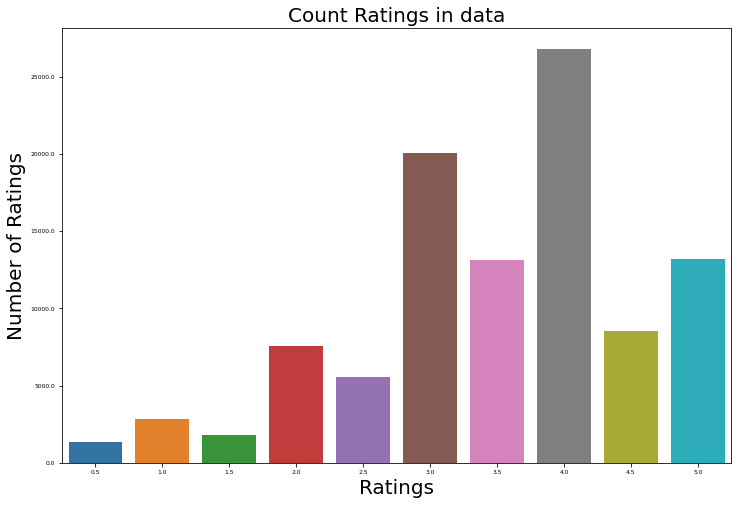

In [ ]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=ratings_df)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 6)
plt.title("Count Ratings in data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

**Tiền xử lý dữ liệu**

In [ ]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)



"{0} movies deleted; all movies are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.movieId.value_counts()) - len(ratings_flrd_df.movieId.value_counts())\
        ,min_movie_ratings,ratings_df.shape, ratings_flrd_df.shape )

'3446 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (100836, 4); New dimensions: (97390, 4)'

In [ ]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

# **SVD**

**n_factor and rmse**

In [ ]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 50, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

In [ ]:
rmse_svd = rmse_vs_factors(SVD,data)

In [ ]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

In [ ]:
plot_rmse(rmse_svd,"SVD")

NameError: ignored

In [ ]:

param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8633896864030686
{'n_factors': 9}


In [ ]:
listtime=[]

In [ ]:
start_time=time.time()
algo_SVD = SVD(n_factors = 9)
algo_SVD.fit(trainset)
end_time=time.time()
print("time",end_time-start_time)
listtime.append(end_time-start_time)
# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

time 1.5136358737945557


[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.869807869390757, details={'was_impossible': False})]

In [ ]:
cross_validate(algo_SVD, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8578  0.8674  0.8625  0.8714  0.8641  0.8646  0.0046  
MAE (testset)     0.6605  0.6665  0.6628  0.6687  0.6636  0.6644  0.0029  
Fit time          1.50    1.45    1.44    1.43    1.43    1.45    0.02    
Test time         0.14    0.13    0.14    0.13    0.13    0.13    0.00    


{'fit_time': (1.4959588050842285,
  1.445134162902832,
  1.4384031295776367,
  1.4332506656646729,
  1.4314205646514893),
 'test_mae': array([0.66048085, 0.66649924, 0.66276053, 0.66865889, 0.66357404]),
 'test_rmse': array([0.85778655, 0.86744682, 0.86254006, 0.87138585, 0.86408647]),
 'test_time': (0.1351304054260254,
  0.13464903831481934,
  0.13819503784179688,
  0.1304616928100586,
  0.1300818920135498)}

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [ ]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [ ]:
hist_SVD_124.head(15)

,userId,movieId,rating,timestamp,title,genres
0,124,1358,5.0,1336409590,Sling Blade (1996),Drama
1,124,3949,5.0,1336413175,Requiem for a Dream (2000),Drama
2,124,7361,5.0,1336413015,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,6377,5.0,1336584435,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,2858,5.0,1336584459,American Beauty (1999),Drama|Romance
5,124,356,5.0,1336423402,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,608,5.0,1336412883,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,3252,4.5,1336409712,Scent of a Woman (1992),Drama
8,124,1210,4.5,1336584462,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,1196,4.5,1336584447,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [ ]:
pred_SVD_124

,userId,movieId,rat_pred,title,genres
0,124,904,4.578938,Rear Window (1954),Mystery|Thriller
1,124,2959,4.550470,Fight Club (1999),Action|Crime|Drama|Thriller
2,124,750,4.546701,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
3,124,4973,4.540761,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
4,124,1204,4.536814,Lawrence of Arabia (1962),Adventure|Drama|War
5,124,1104,4.513844,"Streetcar Named Desire, A (1951)",Drama
6,124,898,4.501623,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
7,124,1208,4.494838,Apocalypse Now (1979),Action|Drama|War
8,124,48516,4.487209,"Departed, The (2006)",Crime|Drama|Thriller
9,124,1199,4.485605,Brazil (1985),Fantasy|Sci-Fi


# **SVD++**

In [ ]:
rmse_svdpp= rmse_vs_factors(SVDpp,data)

KeyboardInterrupt: ignored

In [ ]:
plot_rmse(rmse_svdpp,"SVD++")

NameError: ignored

In [ ]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8534829560675412
{'n_factors': 9}


In [ ]:
start_time=time.time()
algo_SVDpp= SVDpp(n_factors = 9)
algo_SVDpp.fit(trainset)
end_time=time.time()
print("time",end_time-start_time)
listtime.append(end_time-start_time)
# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVDpp.test(testset)

# subset of the list  predictions
predictions[0:2]

time 371.11290884017944


[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.925137863167412, details={'was_impossible': False})]

In [ ]:
cross_validate(algo_SVDpp, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8557  0.8595  0.8428  0.8598  0.8597  0.8555  0.0065  
MAE (testset)     0.6548  0.6580  0.6460  0.6584  0.6589  0.6552  0.0048  
Fit time          245.27  246.61  246.04  246.58  246.62  246.22  0.52    
Test time         7.51    7.68    7.84    7.48    7.34    7.57    0.17    


{'fit_time': (245.2719099521637,
  246.60940599441528,
  246.03740429878235,
  246.58404970169067,
  246.6193404197693),
 'test_mae': array([0.65481127, 0.65798479, 0.64599398, 0.65837803, 0.65887987]),
 'test_rmse': array([0.85570863, 0.85952463, 0.8427883 , 0.85979834, 0.85974567]),
 'test_time': (7.513282775878906,
  7.675931692123413,
  7.843829154968262,
  7.484695911407471,
  7.344213008880615)}

In [ ]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [ ]:
hist_SVD_124.head(15)

,userId,movieId,rating,timestamp,title,genres
0,124,1358,5.0,1336409590,Sling Blade (1996),Drama
1,124,3949,5.0,1336413175,Requiem for a Dream (2000),Drama
2,124,7361,5.0,1336413015,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,6377,5.0,1336584435,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,2858,5.0,1336584459,American Beauty (1999),Drama|Romance
5,124,356,5.0,1336423402,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,608,5.0,1336412883,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,3252,4.5,1336409712,Scent of a Woman (1992),Drama
8,124,1210,4.5,1336584462,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,1196,4.5,1336584447,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [ ]:
pred_SVD_124

,userId,movieId,rat_pred,title,genres
0,124,720,5.0,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
1,124,1046,5.0,Beautiful Thing (1996),Drama|Romance
2,124,187,5.0,Party Girl (1995),Comedy
3,124,177593,5.0,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
4,124,2936,5.0,Sullivan's Travels (1941),Adventure|Comedy|Romance
5,124,96004,5.0,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation
6,124,166492,5.0,Office Christmas Party (2016),Comedy
7,124,3451,5.0,Guess Who's Coming to Dinner (1967),Drama
8,124,5747,5.0,Gallipoli (1981),Drama|War
9,124,8132,5.0,Gladiator (1992),Action|Drama


# **NMF**

In [ ]:
rmse_nmf = rmse_vs_factors(NMF,data)

In [ ]:
plot_rmse(rmse_nmf,"nmf")

In [ ]:
my_list=[i for i in range(1,21)]
param_grid = {'n_factors': my_list}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5)
gs.fit(data)



# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9119300491811833
{'n_factors': 19}


In [ ]:
start_time=time.time()
algo_NMF = NMF(n_factors = 19)
algo_NMF.fit(trainset)
end_time=time.time()
print("time",end_time-start_time)
listtime.append(end_time-start_time)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)
# subset of the list  predictions
predictions[0:2]

time 7.169093608856201


[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=5, details={'was_impossible': False})]

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [ ]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,1213,5.0,Goodfellas (1990),Crime|Drama
1,124,80906,5.0,Inside Job (2010),Documentary
2,124,898,5.0,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
3,124,1046,5.0,Beautiful Thing (1996),Drama|Romance
4,124,1250,5.0,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War
5,124,2019,5.0,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
6,124,3508,5.0,"Outlaw Josey Wales, The (1976)",Action|Adventure|Drama|Thriller|Western
7,124,750,5.0,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
8,124,111,5.0,Taxi Driver (1976),Crime|Drama|Thriller
9,124,1193,5.0,One Flew Over the Cuckoo's Nest (1975),Drama


**KNN**

In [ ]:
from surprise import KNNWithMeans

In [ ]:
sim_options = {
    "name": ["msd", "cosine","pearson"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
start_time=time.time()
my_k = 15
my_min_k = 5
sim_options={'name': 'pearson', 'min_support': 5, 'user_based': True}
algo = KNNWithMeans(sim_options=sim_options
    )
algo.fit(trainset)
end_time=time.time()
print("time",end_time-start_time)
listtime.append(end_time-start_time)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
# subset of the list  predictions
predictions[0:2]

Computing the pearson similarity matrix...
Done computing similarity matrix.
time 0.43614673614501953


[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.819935001151958, details={'actual_k': 40, 'was_impossible': False})]

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [ ]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,720,5.0,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
1,124,1046,5.0,Beautiful Thing (1996),Drama|Romance
2,124,187,5.0,Party Girl (1995),Comedy
3,124,177593,5.0,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
4,124,2936,5.0,Sullivan's Travels (1941),Adventure|Comedy|Romance
5,124,96004,5.0,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation
6,124,166492,5.0,Office Christmas Party (2016),Comedy
7,124,3451,5.0,Guess Who's Coming to Dinner (1967),Drama
8,124,5747,5.0,Gallipoli (1981),Drama|War
9,124,8132,5.0,Gladiator (1992),Action|Drama


**Đánh giá thuật toán**

<Figure size 1440x504 with 0 Axes>

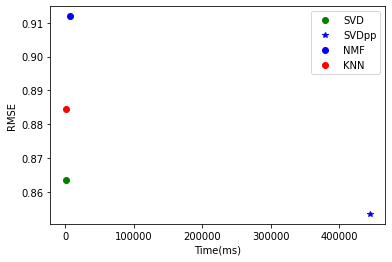

<Figure size 1440x504 with 0 Axes>

In [ ]:
y=[0.8633896864030686,0.8534829560675412,0.9119300491811833,0.8845928158574505]
plt.plot(listtime[0]*1000, y[0],'go',label="SVD")
plt.plot(listtime[1]*1000, y[1],'b*',label="SVDpp")
plt.plot(listtime[2]*1000, y[2],'bo',label="NMF")
plt.plot(listtime[3]*1000, y[3],'ro',label="KNN")
plt.legend(loc="best")
plt.xlabel("Time(ms)")
plt.ylabel("RMSE")
plt.figure(figsize=(20,7))

**Using only the title of the movie**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
movies_df['title'] = movies_df['title'].fillna(" ")
overview_matrix = tfidf.fit_transform(movies_df['title'])
overview_matrix.shape

NameError: ignored

In [ ]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
mapping = pd.Series(movies_df.index,index = movies_df["title"])
def recommend_movies(movie_input):
    movie_index = mapping[movie_input]
    #get similarity values with other movies
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[movie_index]))
    #sort in descending order the similarity score of movie inputted with all the other movies
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 15 most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:15]
    #return movie names using the mapping series
    movie_indices = [i[0] for i in similarity_score]
    return (movies_df["title"].iloc[movie_indices])

In [ ]:
recommend_movies ("Toy Story 2 (1999)")

In [ ]:
avg_movie_rating = pd.DataFrame(ratings_df.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [ ]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


In [ ]:
#Get the average movie rating across all movies 
avg_rating_all=ratings_df['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=5
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.920930,215,1
2,3.431818,110,2
3,3.259615,52,3
4,2.357143,7,4
5,3.071429,49,5


In [ ]:
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,mean,count,movieId,weighted_score
movieId,,,,
1,3.920930,215,1,3.911399
2,3.431818,110,2,3.434850
3,3.259615,52,3,3.280838
4,2.357143,7,4,2.833982
5,3.071429,49,5,3.111255


In [ ]:
movie_score = movie_score.drop(columns = 'movieId')

In [ ]:
movie_score.reset_index()

,movieId,mean,count,weighted_score
0,1,3.920930,215,3.911399
1,2,3.431818,110,3.434850
2,3,3.259615,52,3.280838
3,4,2.357143,7,2.833982
4,5,3.071429,49,3.111255
...,...,...,...,...
3263,177765,3.538462,13,3.528210
3264,179401,3.666667,6,3.591617
3265,179819,3.125000,12,3.235752
3266,180031,3.687500,8,3.615983


In [ ]:
movie_score = pd.merge(movie_score,movies_df,on='movieId')
movie_score.head()

,movieId,mean,count,weighted_score,title,genres
0,1,3.920930,215,3.911399,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.431818,110,3.434850,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.259615,52,3.280838,Grumpier Old Men (1995),Comedy|Romance
3,4,2.357143,7,2.833982,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.071429,49,3.111255,Father of the Bride Part II (1995),Comedy
